In [1]:

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

np.random.seed(42)

In [2]:
# columns used frequently
"EXTN_TPRT", "DWP_TPRT", "EXTN_SRQT", 
"INNER_HMDT_1", "INNER_HMDT_2",
"INNER_TPRT_1", "INNER_TPRT_2"

('INNER_TPRT_1', 'INNER_TPRT_2')

# define useful functions

In [3]:
def describe_df(df):
    print(df.describe())
    plt.figure(figsize=(15, 5)) 
    plt.plot(df)
    plt.suptitle('Original Dataset')
    plt.show()

In [4]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

def preprocess(df):
    sc = MinMaxScaler()
    training_data = sc.fit_transform(df)

    seq_length = 4
    x, y = sliding_windows(training_data, seq_length)
    train_size = int(len(y) * 0.8)
    test_size = len(y) - train_size

    print(x.shape, y.shape)

    dataX = Variable(torch.Tensor(np.array(x)))
    dataY = Variable(torch.Tensor(np.array(y)))

    trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
    trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

    testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
    testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

    print(trainX.shape, trainY.shape, testX.shape, testY.shape, sep="\n")
    print(trainX[0], trainY[0])
    print(trainX[1], trainY[1])
    print((trainX[1][-1]==trainY[0]).all())

    return train_size, sc, dataX, dataY, trainX, trainY, testX, testY 

In [5]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        # self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        # self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [6]:
def train(trainX, trainY, epoch=None):
    num_epochs = epoch if epoch else 2000
    learning_rate = 0.01

    input_size = trainX.shape[-1]
    hidden_size = 4
    num_layers = 1

    num_classes = trainY.shape[-1] # output_size

    lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

    criterion = torch.nn.MSELoss()    # mean-squared error for regression
    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

    # Train the model
    for epoch in range(num_epochs):
        outputs = lstm(trainX)
        optimizer.zero_grad()
        
        # obtain the loss function
        loss = criterion(outputs, trainY)
        
        loss.backward()
        
        optimizer.step()
        if epoch % 100 == 0:
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
    return lstm

In [7]:
import sys 

def parameter_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / 1024**2
    print('parameter size: {:.6f}MB'.format(size_all_mb))
    print('model dict size:', sys.getsizeof(model.state_dict()))

def save_model(model):
    parameter_size(model)
    torch.save(model.state_dict(), "./models/lstm.pt")

In [8]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

def eval(lstm, X, Y, sc, train_size=None):
    lstm.eval()
    train_predict = lstm(X)
    print("X dataset shape & prediction shape:", X.shape, train_predict.shape)

    predict = train_predict.data.numpy()
    Y_plot = Y.data.numpy()

    predict = sc.inverse_transform(predict)
    Y_plot = sc.inverse_transform(Y_plot)

    regression_results(Y_plot, predict)

    plt.figure(figsize=(15, 5)) 
    if train_size:
        plt.axvline(x=train_size, c='r', linestyle='--')
    plt.plot(Y_plot)
    plt.plot(predict, linestyle='dotted')
    plt.suptitle('Time-Series Prediction')
    plt.show()

# 5min step

       INNER_TPRT_1
count   5000.000000
mean      17.322960
std        2.703058
min       13.430000
25%       15.350000
50%       16.400000
75%       18.570000
max       27.050000


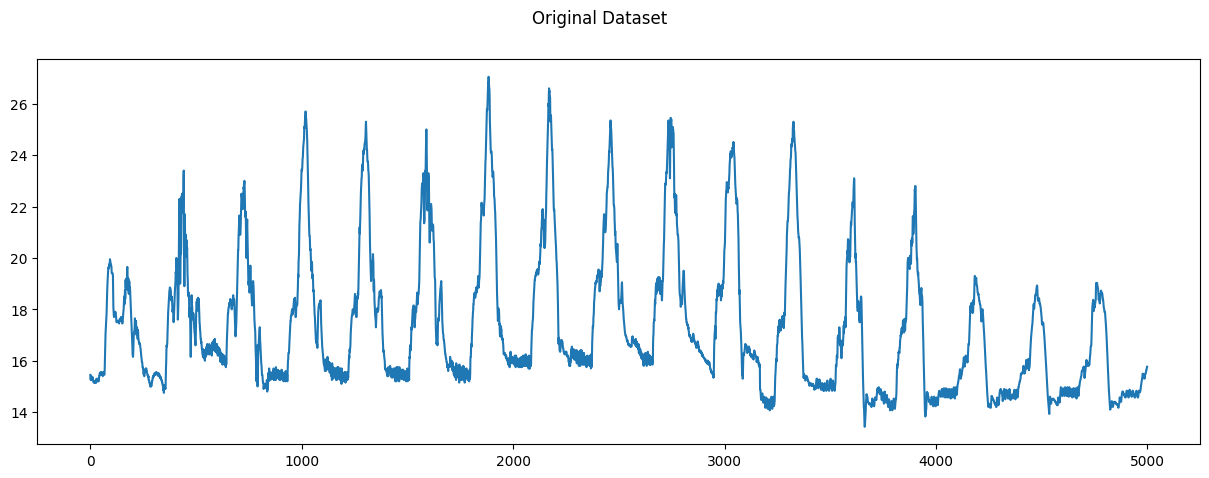

In [9]:
raw_df = pd.read_csv("merged.csv", usecols=["INNER_TPRT_1"]) #, "EXTN_TPRT", "INNER_HMDT_1"])
df = raw_df[:5000]
# df["MSRM_DT"] = (pd.to_datetime(df["MSRM_DT"]) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

describe_df(df)

In [10]:
train_size, sc, dataX, dataY, trainX, trainY, testX, testY = preprocess(df)

(4995, 4, 1) (4995, 1)
torch.Size([3996, 4, 1])
torch.Size([3996, 1])
torch.Size([999, 4, 1])
torch.Size([999, 1])
tensor([[0.1483],
        [0.1373],
        [0.1336],
        [0.1373]]) tensor([0.1410])
tensor([[0.1373],
        [0.1336],
        [0.1373],
        [0.1410]]) tensor([0.1446])
tensor(True)


In [11]:
lstm = train(trainX, trainY)

Epoch: 0, loss: 0.87258
Epoch: 100, loss: 0.03331
Epoch: 200, loss: 0.00092
Epoch: 300, loss: 0.00078
Epoch: 400, loss: 0.00068
Epoch: 500, loss: 0.00057
Epoch: 600, loss: 0.00047
Epoch: 700, loss: 0.00039
Epoch: 800, loss: 0.00034
Epoch: 900, loss: 0.00030
Epoch: 1000, loss: 0.00028
Epoch: 1100, loss: 0.00027
Epoch: 1200, loss: 0.00026
Epoch: 1300, loss: 0.00026
Epoch: 1400, loss: 0.00026
Epoch: 1500, loss: 0.00026
Epoch: 1600, loss: 0.00026
Epoch: 1700, loss: 0.00026
Epoch: 1800, loss: 0.00025
Epoch: 1900, loss: 0.00025


In [12]:
save_model(lstm)

parameter size: 0.000446MB
model dict size: 744


X dataset shape & prediction shape: torch.Size([4995, 4, 1]) torch.Size([4995, 1])
explained_variance:  0.9946
mean_squared_log_error:  1e-04
r2:  0.9946
MAE:  0.1339
MSE:  0.0391
RMSE:  0.1978


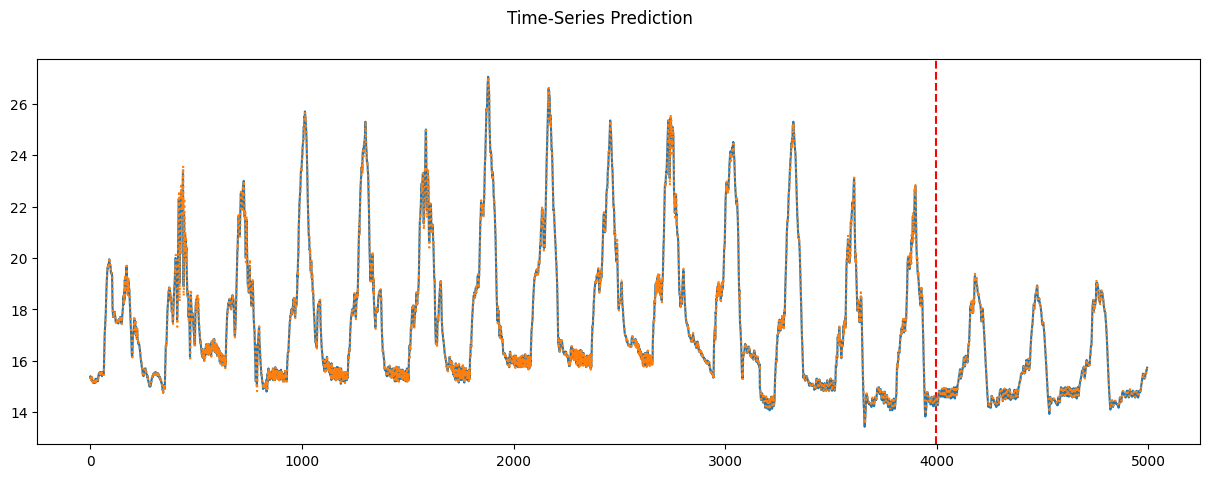

In [13]:
eval(lstm, dataX, dataY, sc, train_size)

X dataset shape & prediction shape: torch.Size([999, 4, 1]) torch.Size([999, 1])
explained_variance:  0.9963
mean_squared_log_error:  0.0
r2:  0.9962
MAE:  0.0684
MSE:  0.0076
RMSE:  0.0874


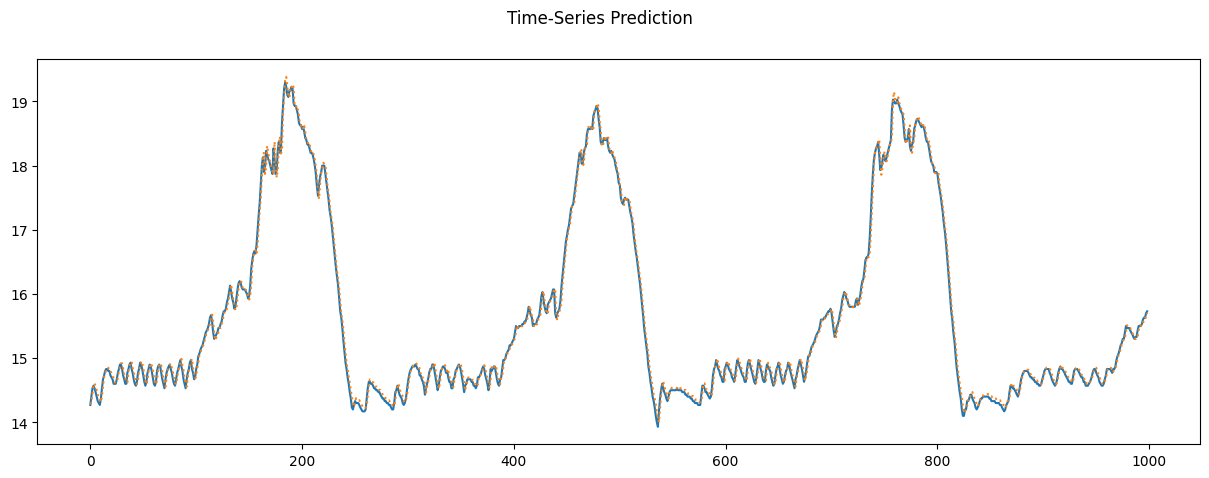

In [14]:
eval(lstm, testX, testY, sc)

# 1hour step

       INNER_TPRT_1
count   2016.000000
mean      18.834410
std        4.679379
min       12.030000
25%       14.870000
50%       17.600000
75%       21.830000
max       34.500000


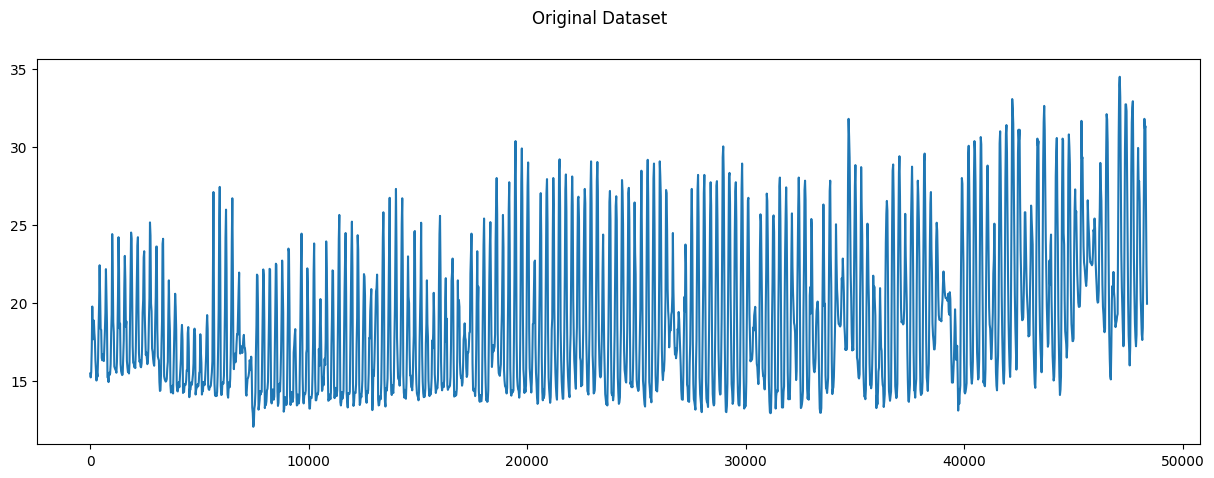

In [15]:
df1h = raw_df[::24]
describe_df(df1h)

In [16]:
train_size, sc, dataX, dataY, trainX, trainY, testX, testY = preprocess(df1h)

(2011, 4, 1) (2011, 1)
torch.Size([1608, 4, 1])
torch.Size([1608, 1])
torch.Size([403, 4, 1])
torch.Size([403, 1])
tensor([[0.1522],
        [0.1411],
        [0.1567],
        [0.2234]]) tensor([0.3436])
tensor([[0.1411],
        [0.1567],
        [0.2234],
        [0.3436]]) tensor([0.2568])
tensor(True)


In [17]:
lstm = train(trainX, trainY)

Epoch: 0, loss: 0.18370


Epoch: 100, loss: 0.01959
Epoch: 200, loss: 0.00667
Epoch: 300, loss: 0.00454
Epoch: 400, loss: 0.00427
Epoch: 500, loss: 0.00426
Epoch: 600, loss: 0.00426
Epoch: 700, loss: 0.00425
Epoch: 800, loss: 0.00425
Epoch: 900, loss: 0.00424
Epoch: 1000, loss: 0.00424
Epoch: 1100, loss: 0.00424
Epoch: 1200, loss: 0.00423
Epoch: 1300, loss: 0.00423
Epoch: 1400, loss: 0.00423
Epoch: 1500, loss: 0.00422
Epoch: 1600, loss: 0.00422
Epoch: 1700, loss: 0.00422
Epoch: 1800, loss: 0.00421
Epoch: 1900, loss: 0.00421


In [18]:
save_model(lstm)

parameter size: 0.000446MB
model dict size: 744


X dataset shape & prediction shape: torch.Size([2011, 4, 1]) torch.Size([2011, 1])
explained_variance:  0.876
mean_squared_log_error:  0.0063
r2:  0.8708
MAE:  1.21
MSE:  2.8327
RMSE:  1.6831


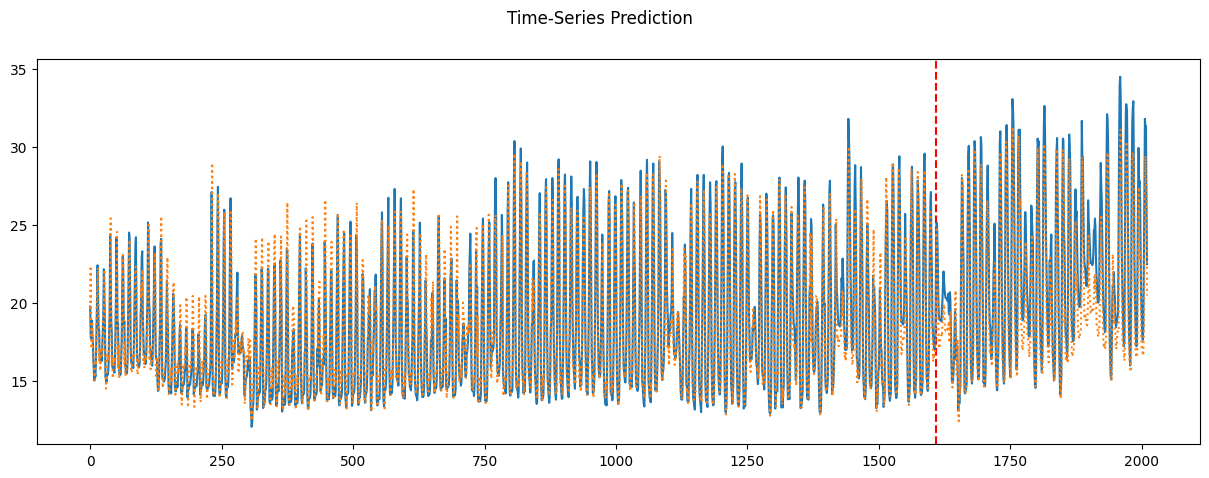

In [19]:
eval(lstm, dataX, dataY, sc, train_size)

X dataset shape & prediction shape: torch.Size([403, 4, 1]) torch.Size([403, 1])
explained_variance:  0.8919
mean_squared_log_error:  0.0108
r2:  0.7832
MAE:  1.8685
MSE:  5.657
RMSE:  2.3784


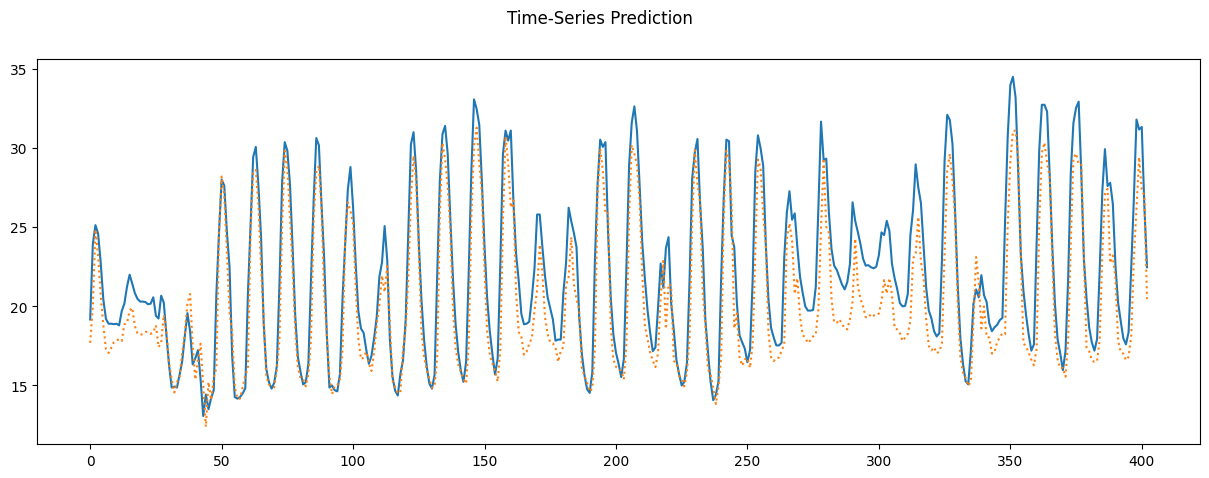

In [20]:
eval(lstm, testX, testY, sc)